<a href="https://colab.research.google.com/github/jimitogni/ml_study/blob/master/catsxdogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import requests

url = 'https://storage.googleapis.com/kaggle-competitions-data/kaggle/5441/all.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1575766845&Signature=Qq9uyycrNfDoTGXoKv2RbG%2FP1ShUYTKtHmmhF%2FVdHCEXm%2FdAAg1TB369jo7JL9iA7x%2Bg8HmSQ4%2FVjU5OZpEReCVjCuEVzFVnt%2FMrz9hTY4zSJJGY6t97Ug%2BEoWhZhN9tjo53SZGvG2KVC%2FFlJ5cSXKUL8v4wx%2BgT48cfe851NspDnFs3ND%2Fi0U95IvyFKZMyReQ0%2Fx80b%2F5pTuVlaMWdRoODu4hwcUhbEkbw6OgYv3OGttc6ZmnCZz66w31KcSCXNKEvUr7G2f74H%2BtdN%2BiO3iIiznBE1qx5DYhz5IXFNDq2NZ8Tz%2BJUMf2BlY%2BstboddIQVpRSo%2BSSHR1qUA%2FLg3w%3D%3D&response-content-disposition=attachment%3B+filename%3Ddogs-vs-cats-redux-kernels-edition.zip'
r = requests.get(url, allow_redirects=True)
open('dogs-vs-cats-redux-kernels-edition.zip', 'wb').write(r.content)

853083283

In [0]:
!unzip dogs-vs-cats-redux-kernels-edition.zip

Archive:  dogs-vs-cats-redux-kernels-edition.zip
  inflating: train.zip               
  inflating: sample_submission.csv   
  inflating: test.zip                


In [0]:
!unzip test.zip 

Archive:  test.zip
   creating: test/
  inflating: test/1.jpg              
  inflating: test/10.jpg             
  inflating: test/100.jpg            
  inflating: test/1000.jpg           
  inflating: test/10000.jpg          
  inflating: test/10001.jpg          
  inflating: test/10002.jpg          
  inflating: test/10003.jpg          
  inflating: test/10004.jpg          
  inflating: test/10005.jpg          
  inflating: test/10006.jpg          
  inflating: test/10007.jpg          
  inflating: test/10008.jpg          
  inflating: test/10009.jpg          
  inflating: test/1001.jpg           
  inflating: test/10010.jpg          
  inflating: test/10011.jpg          
  inflating: test/10012.jpg          
  inflating: test/10013.jpg          
  inflating: test/10014.jpg          
  inflating: test/10015.jpg          
  inflating: test/10016.jpg          
  inflating: test/10017.jpg          
  inflating: test/10018.jpg          
  inflating: test/10019.jpg          
  inflating:

In [0]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel BA1/4hler for this suggestion

TRAIN_DIR = './train'
TEST_DIR = './test'
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'dogsvscats-LR:{}-{}.model'.format(LR, '2conv-basic') # just so we remember which saved model is which, sizes must match

In [0]:
def label_img(img):
    word_label = img.split('.')[-3]
    # conversion to one-hot array [cat,dog]
    #                            [much cat, no dog]
    if word_label == 'cat': return [1,0]
    #                             [no cat, very doggo]
    elif word_label == 'dog': return [0,1]

In [0]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [0]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [0]:
train_data = create_train_data()
# If you have already created the dataset:
#train_data = np.load('train_data.npy')

100%|██████████| 25000/25000 [00:29<00:00, 841.12it/s]


In [0]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

In [0]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

INFO:tensorflow:Restoring parameters from /content/dogsvscats-LR:0.001-2conv-basic.model


NotFoundError: ignored

In [0]:
train = train_data[:-500]
test = train_data[-500:]

In [0]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

In [0]:
import tensorflow as tf
tf.reset_default_graph()
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')



if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 6127  | total loss: 0.31114 | time: 91.774s
| Adam | epoch: 003 | loss: 0.31114 - acc: 0.8671 -- iter: 24448/24500
Training Step: 6128  | total loss: 0.30686 | time: 93.019s
| Adam | epoch: 003 | loss: 0.30686 - acc: 0.8694 | val_loss: 0.45252 - val_acc: 0.7900 -- iter: 24500/24500
--


In [0]:
model.save(MODEL_NAME)

INFO:tensorflow:/content/dogsvscats-LR:0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


In [0]:
import tensorflow as tf
tf.reset_default_graph()
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')



if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

model.save(MODEL_NAME)

Training Step: 9957  | total loss: 0.15996 | time: 88.506s
| Adam | epoch: 010 | loss: 0.15996 - acc: 0.9321 -- iter: 24448/24500
Training Step: 9958  | total loss: 0.16633 | time: 89.751s
| Adam | epoch: 010 | loss: 0.16633 - acc: 0.9280 | val_loss: 0.77954 - val_acc: 0.7900 -- iter: 24500/24500
--
INFO:tensorflow:/content/dogsvscats-LR:0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


100%|██████████| 12500/12500 [00:14<00:00, 861.60it/s]


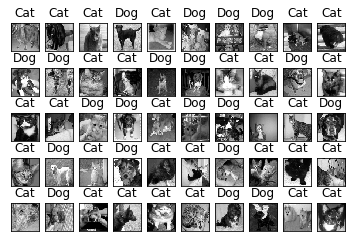

In [0]:
import matplotlib.pyplot as plt

# if you need to create the data:
test_data = process_test_data()
# if you already have some saved:
#test_data = np.load('test_data.npy')

fig=plt.figure()

for num,data in enumerate(test_data[:50]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(5,10,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()